**Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [2]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install farm-haystack
import os
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from subprocess import Popen, PIPE, STDOUT
from datasets import get_dataset_config_names
from datasets import load_dataset
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from haystack.document_stores import ElasticsearchDocumentStore

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

INFO - haystack.modeling.model.optimization -  apex not found, won't use it. See https://nvidia.github.io/apex/
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for

**The Dataset**
- We will use **SubjQA** dataset which consists of more than 10,000 customer reviews in English about products and services.

In [3]:
#@ LOADING THE DATASET:
domains = get_dataset_config_names("subjqa")                # Getting domain names. 
domains                                                     # Inspection.

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [4]:
#@ LOADING THE DATASET:
subjqa = load_dataset("subjqa", name="electronics")         # Initializing electronics qa. 
print(subjqa["train"]["answers"][1])                        # Inspecting answers.

WARNING - datasets.builder -  Reusing dataset subjqa (/root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [5]:
#@ INSPECTING THE DATASET:
dfs = {split: dset.to_pandas() for split,dset in subjqa.flatten().items()}  # Initialization.
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")          # Inspecton.

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [6]:
#@ PREPARING THE DATASET: 
qa_cols = ["title", "question", "answers.text", "answers.answer_start", 
           "context"]                                                       # Initialization.
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)                 # Initializing sample dataframe. 
sample_df                                                                   # Inspecting dataframe.

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


In [7]:
#@ INSPECTING THE ANSWER:
start_index = sample_df["answers.answer_start"].iloc[0][0]                  # Initializing starting index.
end_index = start_index + len(sample_df["answers.text"].iloc[0][0])         # Initializing ending index.
sample_df["context"].iloc[0][start_index:end_index]                         # Inspecting answer.

'this keyboard is compact'

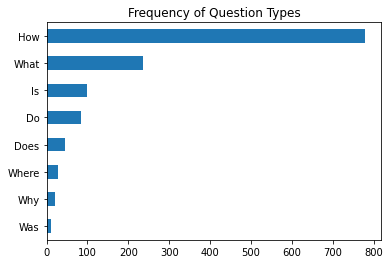

In [8]:
#@ INSPECTING THE QUESTION:
counts = {}                                                                       # Initialization.
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where","Why"]        # Initializing question words.
for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]   # Initializing value counts.
pd.Series(counts).sort_values().plot.barh()                                       # Creating plots.
plt.title("Frequency of Question Types")                                          # Initialization.
plt.show()                                                                        # Inspection. 

In [9]:
#@ INSPECTING QUESTIONS WITH START WORDS: 
for question_type in ["How", "What", "Is"]:
    for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)]
                     .sample(n=3, random_state=2022)["question"]):
        print(question)

How are the bass?
How is the camera?
How is the speed?
What is the quality of the customer service?
What do you think about detail?
What is amount?
Is the option available?
Is the hole big or small?
Is this how zoom works?


**Extracting Answers**

In [10]:
#@ TOKENIZING TEXT FOR QUESTION ANSWERING: SAMPLE EXAMPLE:
model_ckpt = "deepset/minilm-uncased-squad2"                        # Initializing model checkpoint.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)               # Initializing pretrained tokenizer.
question = "How much music can this hold?"                          # Initializing question.
context = "An MP3 is about 1 MB/minute, so about 6000 hours \
           depending on file size."                                 # Initializing context.
inputs = tokenizer(question, context, return_tensors="pt")          # Initializing input tensors.
print(tokenizer.decode(inputs["input_ids"][0]))                     # Decoding IDs. 

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


**Training Model**

In [11]:
#@ TRAINING THE QA MODEL:
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)   # Initializing pretrained model.
with torch.no_grad():                                               # Clearing gradients.
    outputs = model(**inputs)                                       # Implementation of model.
print(outputs)                                                      # Inspection.

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [12]:
#@ INSPECTING MODEL OUTPUT ANSWERS: 
start_logits = outputs.start_logits                                 # Initializing output start logits.
end_logits = outputs.end_logits                                     # Initializing output end logits.
print(f"Input IDs shape: {inputs.input_ids.size()}")                # Inspection. 
print(f"Start logits shape: {start_logits.size()}")                 # Inspection.
print(f"End logits shape: {end_logits.size()}")                     # Inspection. 

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [13]:
#@ DECODING THE OUTPUT LOGITS:
start_idx = torch.argmax(start_logits)                              # Index of maximum tensor.
end_idx = torch.argmax(end_logits) + 1                              # Index of maximum tensor.
answer_span = inputs["input_ids"][0][start_idx:end_idx]             # Initializing answers.
answer = tokenizer.decode(answer_span)                              # Decoding answers.
print(f"Question: {question}")                                      # Inspecting question. 
print(f"Answer: {answer}")                                          # Inspecting answer.

Question: How much music can this hold?
Answer: 6000 hours


In [14]:
#@ QUESTION ANSWERING WITH TRANSFORMERS PIPELINE:
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)     # Initializing model pipeline.
pipe(question=question, context=context, topk=3)                            # Inspecting output.

[{'answer': '6000 hours', 'end': 48, 'score': 0.2651623487472534, 'start': 38},
 {'answer': '1 MB/minute, so about 6000 hours',
  'end': 48,
  'score': 0.22082945704460144,
  'start': 16},
 {'answer': '1 MB/minute',
  'end': 27,
  'score': 0.10253474861383438,
  'start': 16}]

In [15]:
#@ INSPECTING QA WITH NO ANSWERS:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'answer': '', 'end': 0, 'score': 0.9068416357040405, 'start': 0}

**Dealing with Long Sequences**

In [16]:
#@ DEALING WITH LONG SEQUENCES:
example = dfs["train"].iloc[0][["question", "context"]]                        # Initializing sample.
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)                                       # Tokenizing with sliding window.
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens.")                          # Inspecting number of tokens. 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Window #0 has 100 tokens.
Window #1 has 88 tokens.


In [17]:
#@ DECODING THE OUTPUTS:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)}\n")                                     # Decoding the outputs.

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]



**Haystack and QA Pipeline**

In [18]:
#@ INITIALIZING A DOCUMENT STORE: ELASTICSEARCH:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [19]:
#@ RUNNING ELASTIC SEARCH:
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
!sleep 30

In [20]:
#@ INSPECTION OF ELASTICSEARCH:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "976148f80a2b",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "L8FrmJifTNGn9sOYCWVwtg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [21]:
#@ INSTANTIATING DOCUMENT STORE:
